# Selecting stars

Create a binned fractional rms plot, and select stars within boxes

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from astropy.stats import sigma_clip
import seaborn as sns
import fitsio
import os
from contextlib import contextmanager
import sys
sys.path.insert(0, '..')
from binmodule import fast_bin
np.random.seed(42)


sns.set(style='ticks', context='poster', rc={'figure.figsize': (16, 10)}, palette='Paired')
colours = sns.color_palette()

In [2]:
skip = 50
fname = '../data/20150911-ng2000-802-custom-flat-high-quality.fits'
hdu = 'tamflux'


with fitsio.FITS(fname) as infile:
    flux = infile[hdu][:, skip:]
    imagelist = infile['imagelist'].read()[skip:]
    ccdx = infile['ccdx'][:, skip:]
    ccdy = infile['ccdy'][:, skip:]

In [3]:
# Some constants

bin_value = 250
nsigmas = 3.

## Catalogue crossmatch

In [4]:
cat = fitsio.read('../ng2000-matched-catalogue.fits', 1)
rmag = cat['r1mag_ppmxl']

In [5]:
med_x, med_y = [np.median(data, axis=1) for data in [ccdx, ccdy]]

In [6]:
sc = sigma_clip(flux, axis=1, sig=nsigmas)
binned = fast_bin(sc, bin_value)
print('%d points per lightcurve' % (binned.shape[1],))

7 points per lightcurve


In [7]:
med_flux = np.median(binned, axis=1)
mad_flux = np.median(np.abs(binned - med_flux[:, np.newaxis]), axis=1)
std_flux = 1.48 * mad_flux
frms = std_flux / med_flux

In [15]:
# Choose box limits
mag_lims = (12, 10.2)
top_frms_lims = (1E-3, 5E-3)
bottom_frms_lims = (1E-4, 1E-3)

In [16]:
def build_rectangle(xlims, ylims, colour):
    return plt.Rectangle(xy=(xlims[0], ylims[0]),
                               width=(xlims[1] - xlims[0]),
                               height=(ylims[1] - ylims[0]),
                               edgecolor=colour,
                               facecolor='None')

In [17]:
@contextmanager
def subplots(*args, **kwargs):
    fig, axes = plt.subplots(*args, **kwargs)
    yield (fig, axes)
    fig.tight_layout()

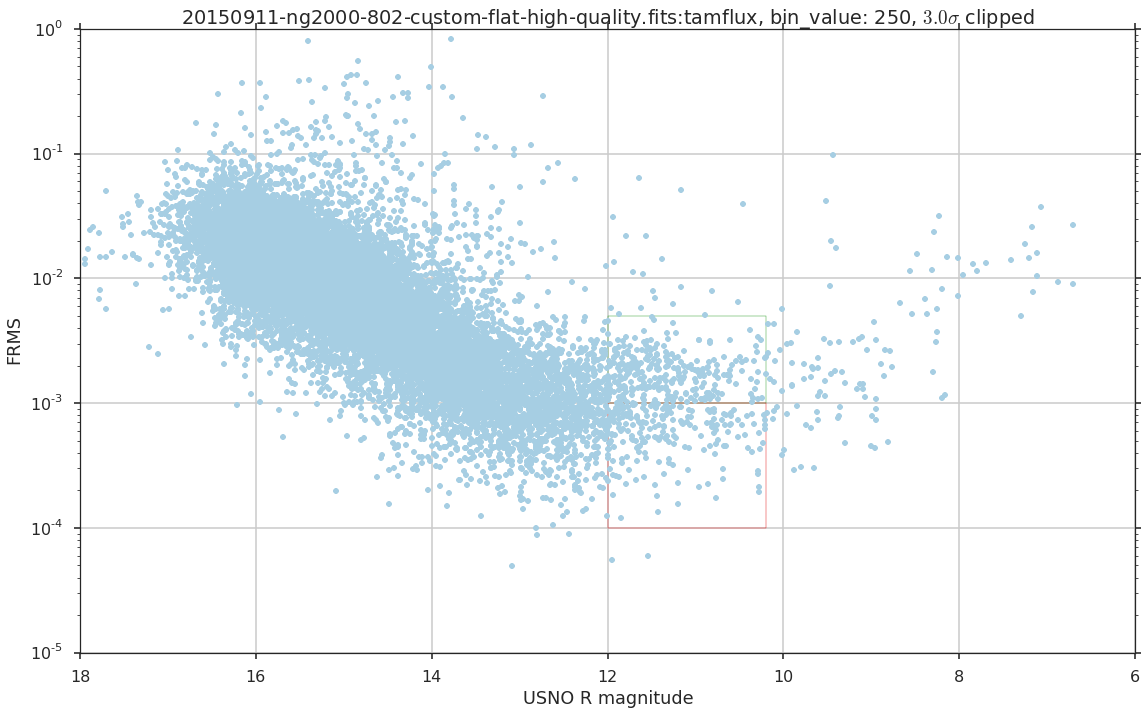

In [18]:
with subplots() as (fig, axis):
    axis.semilogy(rmag, frms, '.')
    axis.invert_xaxis()
    axis.grid(True)
    axis.set(xlabel='USNO R magnitude', ylabel='FRMS',
             title=r'{fname}:{hdu}, bin_value: {bin_value}, ${nsigmas}\sigma$ clipped'.format(
                fname=os.path.basename(fname), bin_value=bin_value, hdu=hdu, nsigmas=nsigmas))
    top_selection_rect = build_rectangle(mag_lims, top_frms_lims, colours[3])
    bottom_selection_rect = build_rectangle(mag_lims, bottom_frms_lims, colours[5])
    axis.add_patch(top_selection_rect)
    axis.add_patch(bottom_selection_rect)
    axis.set(xlim=(18, 6), ylim=(1E-5, 1E0))

There seems to be a break at around 12th magnitude (as seen in other analyses) where these stars seem to separate.

## Separating by performance

In [12]:
def select_stars(xlims, ylims, x_data, y_data, lcs):
    x_ind = (x_data >= min(xlims)) & (x_data < max(xlims))
    y_ind = (y_data >= min(ylims)) & (y_data < max(ylims))
    ind = x_ind & y_ind
    assert ind.any()
    return np.where(ind)[0]

In [13]:
top_ind = select_stars(mag_lims, top_frms_lims, rmag, frms, binned)
bottom_ind = select_stars(mag_lims, bottom_frms_lims, rmag, frms, binned)

print('%d top stars, %d bottom stars' % (top_ind.size, bottom_ind.size))

# Randomly select the same number of stars from each
nstars = min(top_ind.size, bottom_ind.size)
if top_ind.size > nstars:
    top_ind = np.random.choice(top_ind, replace=False, size=nstars)
if bottom_ind.size > nstars:
    bottom_ind = np.random.choice(bottom_ind, replace=False, size=nstars)
    
print('%d top stars, %d bottom stars' % (top_ind.size, bottom_ind.size))

288 top stars, 220 bottom stars
220 top stars, 220 bottom stars


/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


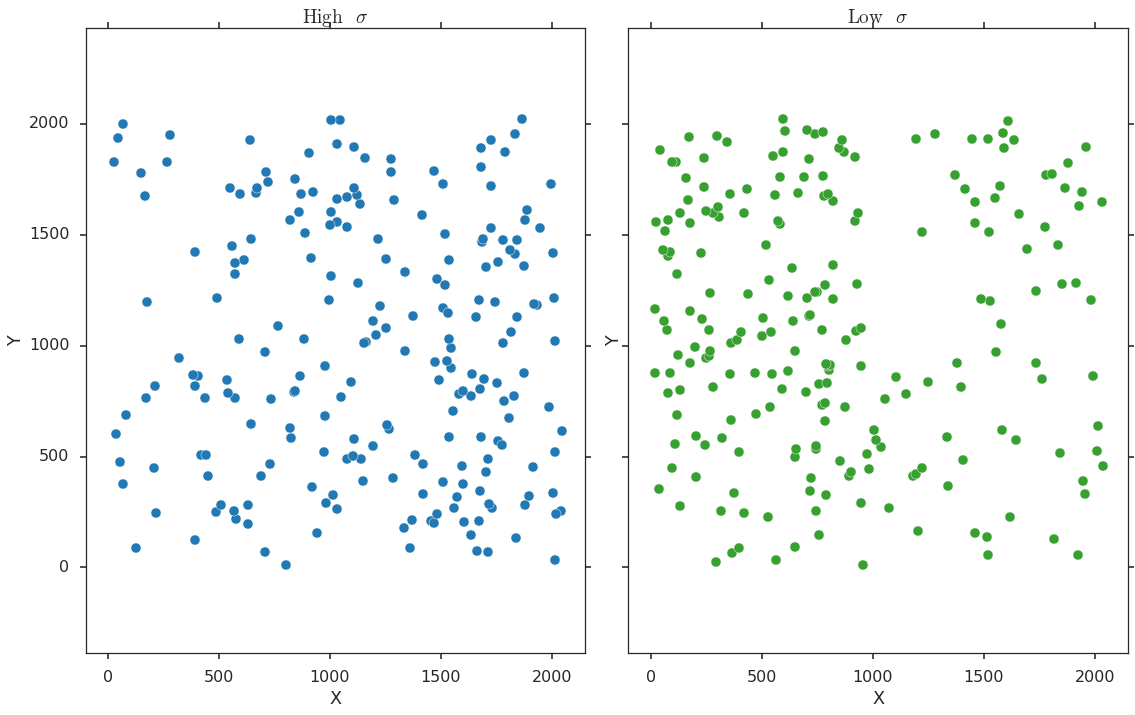

In [14]:
with subplots(1, 2, sharex=True, sharey=True) as (fig, axes):
    s = lambda a, ind, c, label: a.scatter(med_x[ind], med_y[ind], c=c, s=100, label=label)
    s(axes[0], top_ind, colours[1], r'$\mathrm{High}\; \sigma$')
    s(axes[1], bottom_ind, colours[3], r'$\mathrm{Low}\; \sigma$')
    axes[0].set(title=r'$\mathrm{High}\;\sigma$')
    axes[1].set(title=r'$\mathrm{Low}\;\sigma$')
    
    for ax in axes:
        ax.set(xlim=(0, 2047), ylim=(0, 2047), aspect='equal', xlabel='X', ylabel='Y')

## TODO

* Look at stars in the corners and find where they are on the frms diagram
* Look at the long post-tamuz analysis